# Spatial-temporal Kriging

## Učitavanje biblioteka

In [81]:
# Standardne biblioteke
import warnings
from itertools import combinations

# Obrada podataka
import numpy as np
import pandas as pd

# Statističke i matematičke funkcije
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.signal import periodogram
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist

# Machine learning modeli, metrika i evaluacija
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

# Time series modeliranje
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

# Vizualizacija
import matplotlib.pyplot as plt

# Progres bar za petlje
from tqdm import tqdm

# Rad sa Jupyter notebook fajlovima
import nbformat

# Učitavanje lokalnog notebook-a sa grafovima
%run 00_graphs.ipynb

# Isključivanje upozorenja
warnings.filterwarnings('ignore')


## Učitavanje podataka

In [51]:
data = pd.read_csv('data\\pollen_data_with_imputed_dates.csv', parse_dates=['date'])
locations = pd.read_csv('data\\location.csv')
locations.head()
data = data.merge(locations, on='location', how ='left')
meteo_df = pd.read_csv('meteo\meteo_df.csv', parse_dates=['date'])

## Uklanjanje trenda i sezonalnosti iz podataka

### Primer za ambrozija-Požarevac

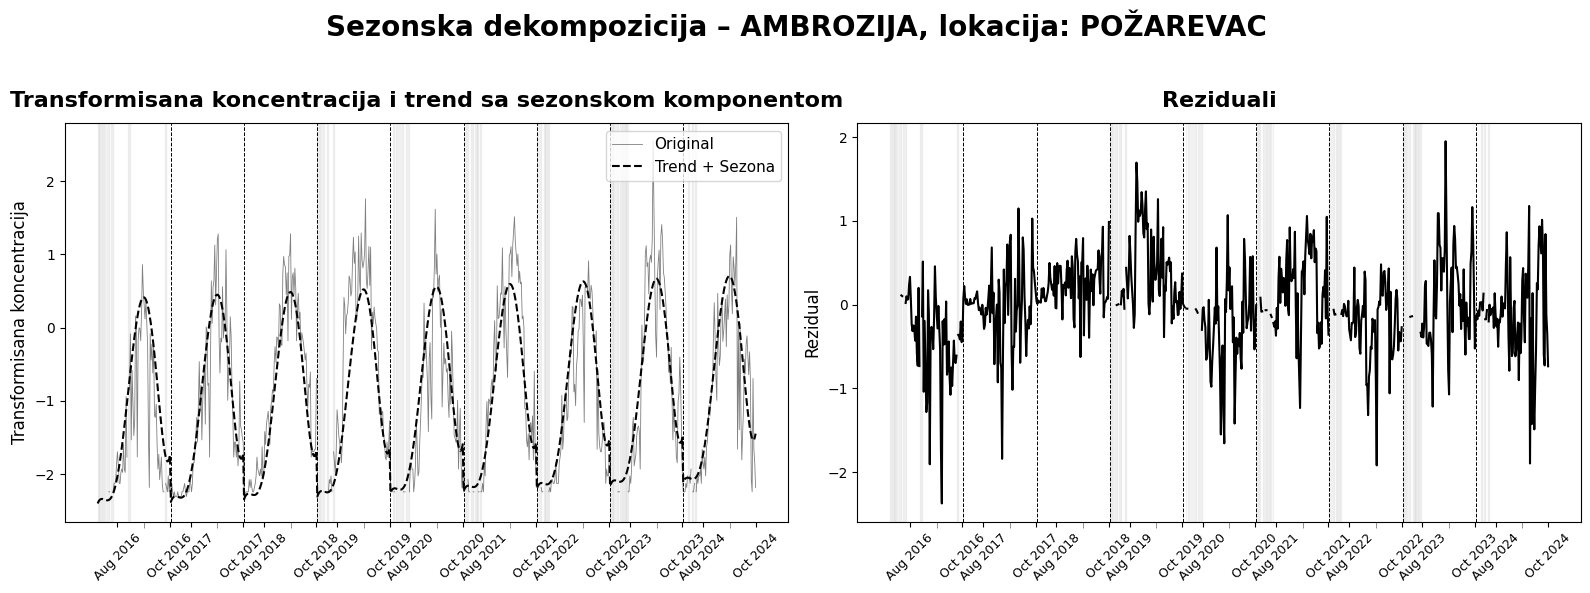

In [30]:
example = ["POŽAREVAC", "AMBROZIJA"]
location, allergen = example

exog_cols = []
meteo = pd.read_csv(f'meteo\\{location}.csv', parse_dates=['date'])

df_allergen = data[(data['allergen'] == allergen) & (~data['value'].isna())].copy()
df_allergen["value_scaled"] = np.nan

# Skaliranje vrednosti po lokacijama
for loc, group in df_allergen.groupby("location"):
    std_value = np.std(group["value"])
    df_allergen.loc[group.index, "value_scaled"] = group["value"] / std_value

# Box-Cox transformacija na skaliranim podacima za ceo alergen
df_allergen["value_pos"] = df_allergen["value_scaled"] + 1e-1
boxcox_transformed, shared_lambda = boxcox(df_allergen["value_pos"])

df_example = data[(data["location"] == location) & (data["allergen"] == allergen)].copy()
df_example = df_example.merge(meteo, on='date', how='left')

# Skaliranje vrednosti za lokaciju
mask_valid = ~df_example["value"].isna()
std_value_loc = df_example.loc[mask_valid, "value"].std()

df_example["value_scaled"] = df_example["value"] / std_value_loc
df_example["value_pos"] = df_example["value_scaled"] + 1e-1

# Zajednička Box-Cox lambda za sve lokacije
if shared_lambda <= 0:
    df_example.loc[mask_valid, "boxcox_value"] = np.log(df_example.loc[mask_valid, "value_pos"])
    shared_lambda = 0
else:
    df_example.loc[mask_valid, "boxcox_value"] = (df_example.loc[mask_valid, "value_pos"] ** shared_lambda - 1) / shared_lambda

# Furije + trend + exog regresija
min_year = df_example["date"].dt.year.min()
min_date = pd.to_datetime(f"{min_year}-01-01")
df_example["t"] = (df_example["date"] - min_date).dt.days

fourier_order = 3
fourier = CalendarFourier(freq='A', order=fourier_order)

dp = DeterministicProcess(
    index=df_example["date"],
    constant=True,
    order=0,
    seasonal=False,
    additional_terms=[fourier],
    drop=True
)

X_fourier = dp.in_sample()

X_full = X_fourier.reset_index().copy()
X_full = pd.merge(X_full, df_example.loc[:, ["date", "t"] + exog_cols], on='date').drop(columns='date')

y = df_example.loc[mask_valid, "boxcox_value"].copy()
X_fit = X_full.loc[mask_valid]

linear_model = LinearRegression().fit(X_fit, y)

# Predikcija i računanje reziduala
df_example["fitted"] = linear_model.predict(X_full)
df_example.loc[mask_valid, "residual"] = df_example.loc[mask_valid, "boxcox_value"] - df_example.loc[mask_valid, "fitted"]

plot_seasonal_decomposition(df_example, True)

### Uklanjanje trenda i sezonalnosti na celom skupu podata

In [52]:
# Inicijalizacija mapa i konstanti
lambda_map = {}     # Čuva Box-Cox lambdu po alergenu
scale_map = {}      # Čuva standardnu devijaciju po (alergen, lokacija)
epsilon = 1e-1      # Mali offset za pozitivnost kod Box-Cox
processed_allergen_location = []  # Lista za čuvanje obrađenih DataFrame-ova

exog_cols = []

# Grupisanje po alergenima
for allergen, df_allergen in tqdm(data.groupby("allergen"), desc="Obrada alergena"):

    scaled_location_groups = []

    # Skaliranje po lokacijama
    for location, df_loc in df_allergen.groupby("location"):
        df_loc = df_loc.copy()
        valid_mask = ~df_loc["value"].isna()
        std_value = np.std(df_loc.loc[valid_mask, "value"])
        
        scale_map[(allergen, location)] = std_value
        df_loc["value_scaled"] = df_loc["value"] / std_value

        scaled_location_groups.append(df_loc)

    df_scaled = pd.concat(scaled_location_groups, ignore_index=True)

    # Box-Cox transformacija
    valid_mask = ~df_scaled["value_scaled"].isna()
    df_scaled.loc[valid_mask, "value_pos"] = df_scaled.loc[valid_mask, "value_scaled"] + epsilon

    df_scaled.loc[valid_mask, "boxcox_value"], lmbda = boxcox(df_scaled.loc[valid_mask, "value_pos"])
    if lmbda < 0:
        lmbda = 0
        df_scaled.loc[valid_mask, "boxcox_value"] = np.log(df_scaled.loc[valid_mask, "value_pos"])

    lambda_map[allergen] = lmbda

    # Globalni minimalni datum za trend
    global_min_date = pd.to_datetime(df_allergen["date"].min().strftime("%Y-01-01"))

    # Procesiranje po lokacijama unutar alergena
    for location, df_loc in df_scaled.groupby("location"):
        df_loc = df_loc.copy()
        if len(df_loc) < 10 or (~df_loc["value"].isna()).sum() < 5:
            continue

        # Dodavanje meteo podataka za lokaciju
        meteo_loc = meteo_df[meteo_df["location"] == location].copy()
        df_loc = df_loc.merge(meteo_loc, on=["date", "location"], how="left")

        # Rekreiranje maske validnih vrednosti posle merge-a
        valid_mask = ~df_loc["value"].isna()
        if valid_mask.sum() < 5:
            continue

        # Furije + trend + exog regresija
        df_loc["t"] = (df_loc["date"] - global_min_date).dt.days

        fourier = CalendarFourier(freq='A', order=3)
        dp = DeterministicProcess(
            index=df_loc["date"],
            constant=True,
            order=0,
            seasonal=False,
            additional_terms=[fourier],
            drop=True
        )
        X_fourier = dp.in_sample()

        X_full = X_fourier.reset_index().copy()
        X_full = pd.merge(X_full, df_loc.loc[:, ["date", "t"] + exog_cols], on='date')
        X_full.drop(columns='date', inplace=True)

        y = df_loc.loc[valid_mask, "boxcox_value"].copy()
        X_fit = X_full.loc[valid_mask].copy()

        if len(y) == 0 or len(X_fit) == 0:
            continue

        lin_reg = LinearRegression().fit(X_fit, y)

        # Predikcija i rezidual
        df_loc["fitted"] = lin_reg.predict(X_full)
        df_loc["residual"] = df_loc["boxcox_value"] - df_loc["fitted"]

        df_loc["lambda"] = lmbda
        df_loc["scale"] = scale_map[(allergen, location)]

        processed_allergen_location.append(df_loc)

# Konačni rezultat
data_res = pd.concat(processed_allergen_location, ignore_index=True)


Obrada alergena: 100%|██████████| 25/25 [00:38<00:00,  1.56s/it]


## Imputacija nedostajućih podataka pomoću kriginga

### Određivanje variograma za ambroziju

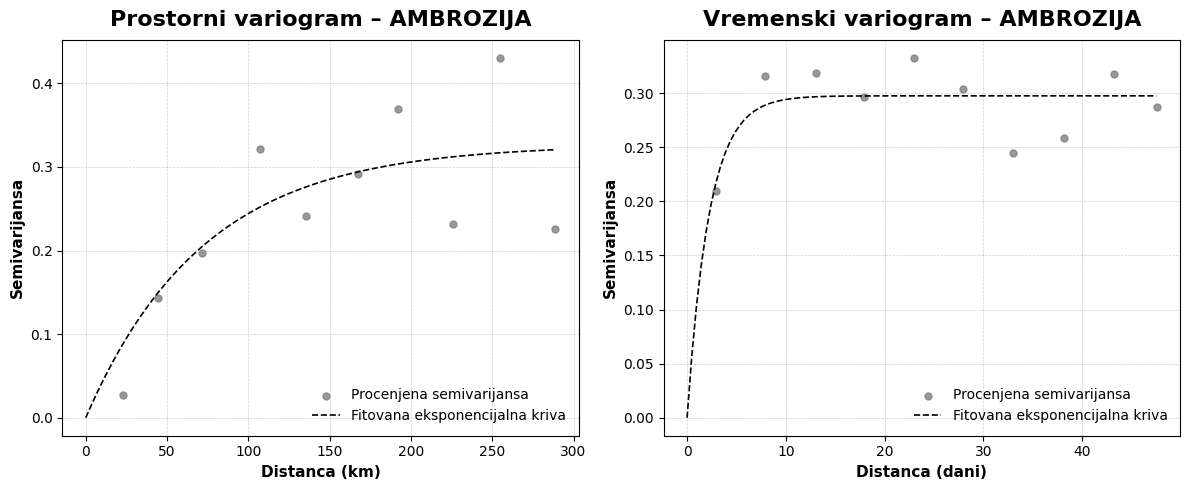

In [33]:
# Eksponencijalni model variograma
def variogram_model(h, C0, C, a):
    return C0 + C * (1 - np.exp(-h / a))

# Funkcija za binovanje i prosečnu vrednost semivariograma po binu
def bin_and_average(distances, semivariances, delta):
    max_distance = distances.max()
    bins = np.arange(0, max_distance + delta, delta)
    df = pd.DataFrame({'distance': distances, 'semivariance': semivariances})
    df['bin'] = pd.cut(df['distance'], bins=bins, include_lowest=True)
    grouped = df.groupby('bin').agg({'distance': 'mean', 'semivariance': 'mean'}).dropna().reset_index()
    return grouped['distance'].values, grouped['semivariance'].values


residual_df = data_res.copy()
allergen = 'AMBROZIJA'
df_allergen = residual_df[(residual_df["allergen"] == allergen) & (~residual_df['value'].isna())]

sample_df = df_allergen.sample(n=min(1000, len(df_allergen)), random_state=42)

coords = sample_df[["latitude", "longitude"]].values * 111  # km
times = sample_df['t'].values
residuals = sample_df['residual'].values
years = sample_df["date"].dt.year.values.reshape(-1, 1)

pairs = list(combinations(range(len(sample_df)), 2))
spatial_distances, semivariances_space = [], []
temporal_distances, semivariances_time = [], []

for i, j in pairs:
    d = np.linalg.norm(coords[i] - coords[j])
    td = np.abs(times[i] - times[j])
    gamma_ij = 0.5 * (residuals[i] - residuals[j]) ** 2
    
    # Prostorni variogram
    if (times[i] == times[j]) and d < 300:
        spatial_distances.append(d)
        semivariances_space.append(gamma_ij)
    
    # Vremenski variogram
    if (d < 1) and (years[i] == years[j]) and (abs(times[i] - times[j]) < 50):
        temporal_distances.append(td)
        semivariances_time.append(gamma_ij)

spatial_distances = np.array(spatial_distances)
semivariances_space = np.array(semivariances_space)
temporal_distances = np.array(temporal_distances)
semivariances_time = np.array(semivariances_time)

# Binovanje za stabilniji fit
spatial_distances_binned, semivariances_space_binned = bin_and_average(spatial_distances, semivariances_space, 30)
temporal_distances_binned, semivariances_time_binned = bin_and_average(temporal_distances, semivariances_time, 5)

# Fitovanje prostornog variograma
params_space, _ = curve_fit(variogram_model, spatial_distances_binned, semivariances_space_binned,
                            p0=[0.1, 1.0, 30], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

# Fitovanje vremenskog variograma
params_time, _ = curve_fit(variogram_model, temporal_distances_binned, semivariances_time_binned,
                        p0=[0.1, 1.0, 10], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

# Generisanje x i y za fitovane krive
x_space = np.linspace(0, spatial_distances_binned.max(), 100)
y_space = variogram_model(x_space, *params_space)

x_time = np.linspace(0, temporal_distances_binned.max(), 100)
y_time = variogram_model(x_time, *params_time)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(spatial_distances_binned, semivariances_space_binned, s=25, alpha=0.8, color='gray', label="Procenjena semivarijansa")
axs[0].plot(x_space, y_space, color='black', linestyle='--', linewidth=1.2, label='Fitovana eksponencijalna kriva')
axs[0].set_title(f"Prostorni variogram – {allergen}", fontsize=16, fontweight='bold', pad=10)
axs[0].set_xlabel("Distanca (km)", fontsize=11, fontweight='bold')
axs[0].set_ylabel("Semivarijansa", fontsize=11, fontweight='bold')
axs[0].legend(loc='lower right', fontsize=10, frameon=False)
axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axs[0].tick_params(axis='both', labelsize=10)

axs[1].scatter(temporal_distances_binned, semivariances_time_binned, s=25, alpha=0.8, color='gray', label="Procenjena semivarijansa")
axs[1].plot(x_time, y_time, color='black', linestyle='--', linewidth=1.2, label='Fitovana eksponencijalna kriva')
axs[1].set_title(f"Vremenski variogram – {allergen}", fontsize=16, fontweight='bold', pad=10)
axs[1].set_xlabel("Distanca (dani)", fontsize=11, fontweight='bold')
axs[1].set_ylabel("Semivarijansa", fontsize=11, fontweight='bold')
axs[1].legend(loc='lower right', fontsize=10, frameon=False)
axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axs[1].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.savefig(f'grafici\\{allergen}_variogrami.png', dpi=300, bbox_inches='tight')
plt.show()

### Računanje variograma i imputacija na celom skupu podataka

In [35]:
# Priprema
results = []
kriging_df = data_res.copy()

# Obrada po alergenima
for allergen in tqdm(kriging_df["allergen"].unique(), desc="Obrada alergena"):

    mask_unknown = (kriging_df["allergen"] == allergen) & (kriging_df["value"].isna())
    mask_known = (kriging_df["allergen"] == allergen) & (~kriging_df["value"].isna())

    # Uzimanje uzorka poznatih podataka za procenu variograma
    sample_known = kriging_df.loc[mask_known].sample(n=min(1000, mask_known.sum()), random_state=42)
    coords = sample_known[["latitude", "longitude"]].values * 111
    times = sample_known["t"].values
    residuals = sample_known["residual"].values
    years = sample_known["date"].dt.year.values.reshape(-1, 1)

    # Generisanje parova indeksa za semivariogram
    pairs = list(combinations(range(len(sample_known)), 2))
    spatial_dists, spatial_semivars = [], []
    temporal_dists, temporal_semivars = [], []

    for i, j in pairs:
        dist = np.linalg.norm(coords[i] - coords[j])
        gamma = 0.5 * (residuals[i] - residuals[j]) ** 2
        # Vremenski variogram
        if (dist < 1) and (years[i] == years[j]) and (abs(times[i] - times[j]) < 50):
            td = np.abs(times[i] - times[j])
            temporal_dists.append(td)
            temporal_semivars.append(gamma)
        # Prostorni variogram
        if (times[i] == times[j]) and dist < 300:
            spatial_dists.append(dist)
            spatial_semivars.append(gamma)

    # Binovanje prostornog i vremenskog variograma
    spatial_distances_binned, semivariances_space_binned = bin_and_average(spatial_distances, semivariances_space, 30)
    temporal_distances_binned, semivariances_time_binned = bin_and_average(temporal_distances, semivariances_time, 5)

    # Fitovanje prostornog variograma
    params_space, _ = curve_fit(variogram_model, spatial_distances_binned, semivariances_space_binned,
                                p0=[0.1, 1.0, 30], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    # Fitovanje vremenskog variograma
    params_time, _ = curve_fit(variogram_model, temporal_distances_binned, semivariances_time_binned,
                            p0=[0.1, 1.0, 10], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    # Određivanje faktora za vremensko skaliranje
    time_scale = np.clip(params_space[2] / params_time[2], 10, 50)
    nugget_s, sill_s, range_s = params_space
    nugget_t, sill_t, range_t = params_time

    # Estimacija parametra k
    g_s_vals, g_t_vals, g_emp_vals = [], [], []

    for i, j in pairs:
        if (years[i] == years[j]) and (abs(times[i] - times[j]) < 50) and (np.linalg.norm(coords[i] - coords[j]) < 300):
            dist_s = np.linalg.norm(coords[i] - coords[j])
            delta_t = abs(times[i] - times[j])
            g_s = variogram_model(np.array([dist_s]), *params_space)[0]
            g_t = variogram_model(np.array([delta_t]), *params_time)[0]
            g_emp = 0.5 * (residuals[i] - residuals[j]) ** 2
            g_s_vals.append(g_s)
            g_t_vals.append(g_t)
            g_emp_vals.append(g_emp)

    g_s_vals, g_t_vals, g_emp_vals = map(np.array, (g_s_vals, g_t_vals, g_emp_vals))
    k_estimates = (g_s_vals + g_t_vals - g_emp_vals) / (g_s_vals * g_t_vals + 1e-8)
    k_param = np.clip(np.mean(k_estimates), 0.1, 1.5)

    # Priprema poznatih i nepoznatih podataka za kriging
    df_unknown = kriging_df.loc[mask_unknown].copy()
    X_known = kriging_df.loc[mask_known, ["latitude", "longitude", "t"]].values
    z_known = kriging_df.loc[mask_known, "residual"].values
    X_unknown = df_unknown[["latitude", "longitude", "t"]].values

    # Skaliranje vremena
    X_known_scaled = np.hstack([X_known[:, :2] * 111, X_known[:, 2:3] * time_scale])
    X_unknown_scaled = np.hstack([X_unknown[:, :2] * 111, X_unknown[:, 2:3] * time_scale])

    # Pretraga suseda
    nn = NearestNeighbors(n_neighbors=50, metric='euclidean')
    nn.fit(X_known_scaled)
    distances, neighbors_idx = nn.kneighbors(X_unknown_scaled, return_distance=True)
    neighbors_idx = [idxs[d < 200] if np.any(d < 200) else [] for d, idxs in zip(distances, neighbors_idx)]

    # IQR za winsorizing
    iqr_stats = kriging_df.loc[mask_known].groupby("location")["residual"].agg(
        q1=lambda x: np.percentile(x, 25),
        q3=lambda x: np.percentile(x, 75)
    )
    iqr_stats["iqr"] = iqr_stats["q3"] - iqr_stats["q1"]
    iqr_stats["upper"] = iqr_stats["q3"] + 2 * iqr_stats["iqr"]

    predictions = []

    # Kriging predikcija po tački
    for i, idx in enumerate(neighbors_idx):
        if len(idx) < 1:
            predictions.append(0.0)
            continue

        X_k = X_known[idx]
        z_k = z_known[idx]
        x_u = X_unknown[i:i + 1]

        d_s = np.linalg.norm(X_k[:, :2] * 111 - x_u[:, :2] * 111, axis=1)
        d_t = np.abs(X_k[:, 2] - x_u[:, 2])
        g_s = variogram_model(d_s, nugget_s, sill_s, range_s)
        g_t = variogram_model(d_t, nugget_t, sill_t, range_t)
        g = g_s + g_t - k_param * g_s * g_t

        D_s = cdist(X_k[:, :2] * 111, X_k[:, :2] * 111)
        D_t = cdist(X_k[:, 2:3], X_k[:, 2:3])
        G_s = variogram_model(D_s, nugget_s, sill_s, range_s)
        G_t = variogram_model(D_t, nugget_t, sill_t, range_t)
        G = G_s + G_t - k_param * G_s * G_t

        n = G.shape[0]
        K = np.zeros((n + 1, n + 1))
        K[:n, :n] = G
        K[n, :-1] = 1
        K[:-1, n] = 1

        weights = np.linalg.solve(K, np.append(g, 1))
        z_pred = np.dot(weights[:-1], z_k)
        predictions.append(z_pred)

    # Winsorizing
    df_unknown["residual_pred"] = predictions
    upper_bounds = df_unknown["location"].map(iqr_stats["upper"]).fillna(np.inf).values
    residual_clipped = np.minimum(np.array(predictions), upper_bounds)

    # Rekonstrukcija originalnih vrednosti
    fitted_values = df_unknown["fitted"].values
    lambda_val = lambda_map.get(allergen, 1.0)
    value_boxcox = fitted_values + residual_clipped
    value_inv = inv_boxcox(value_boxcox, lambda_val) - 1e-1

    locs = df_unknown["location"].values
    scales = np.array([scale_map.get((allergen, loc), 1.0) for loc in locs])
    final_values = np.round(np.clip(value_inv * scales, 0, None), 0)

    df_unknown["value"] = final_values
    kriging_df.loc[df_unknown.index, "value"] = df_unknown["value"]

# Uklanjanje nepotrebnih kolona
kriging_df = kriging_df.drop(columns=[
    'value_scaled', 'value_pos', 'boxcox_value', 
    'temperature', 'precipitation', 'humidity', 'wind', 'wind_direciton'
    't', 'fitted', 'residual', 'lambda', 'scale'
], errors='ignore')
kriging_df.to_csv("data\\spatiotemporal_kriging_predictions.csv", index=False)
print("Kriging završen i rezultati su sačuvani.")


Obrada alergena: 100%|██████████| 25/25 [04:36<00:00, 11.04s/it]


Kriging završen i rezultati su sačuvani.


### Prikaz imputovanih podataka odabranih alergena i gradova

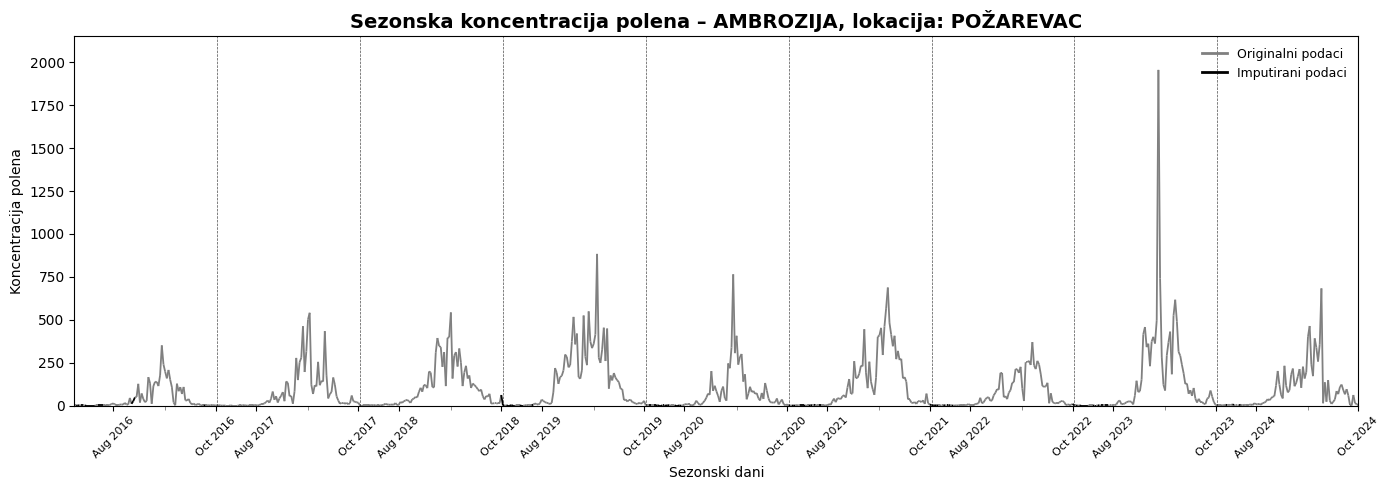

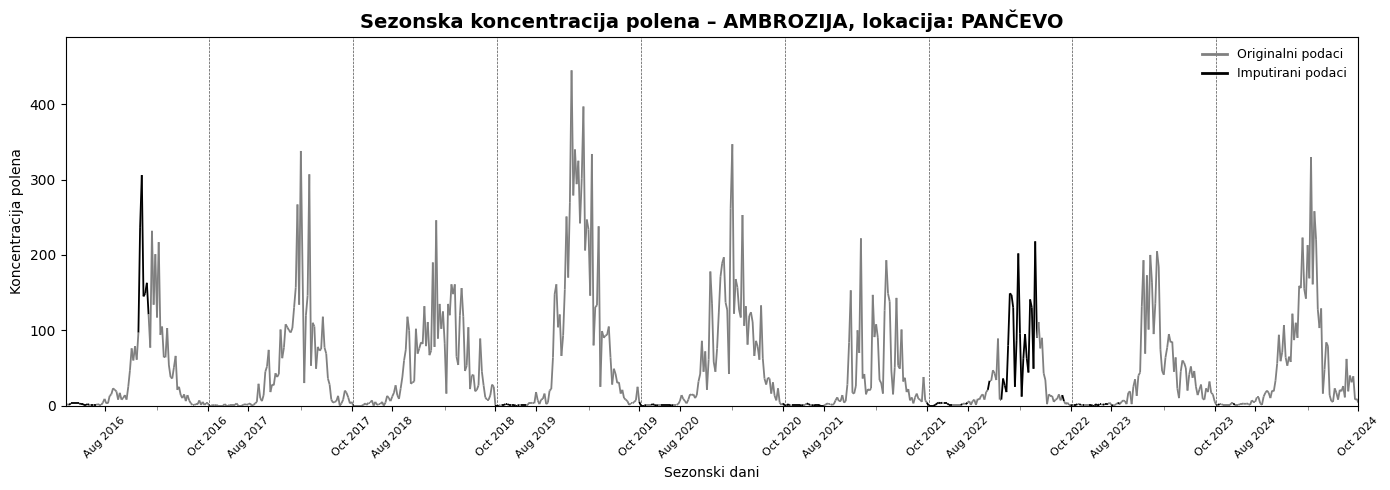

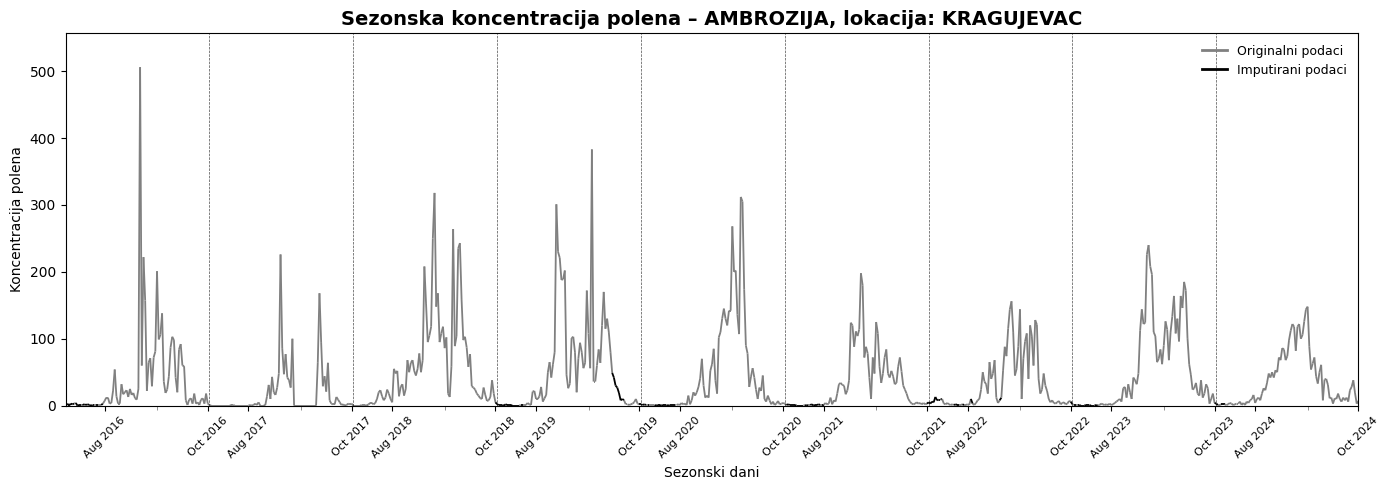

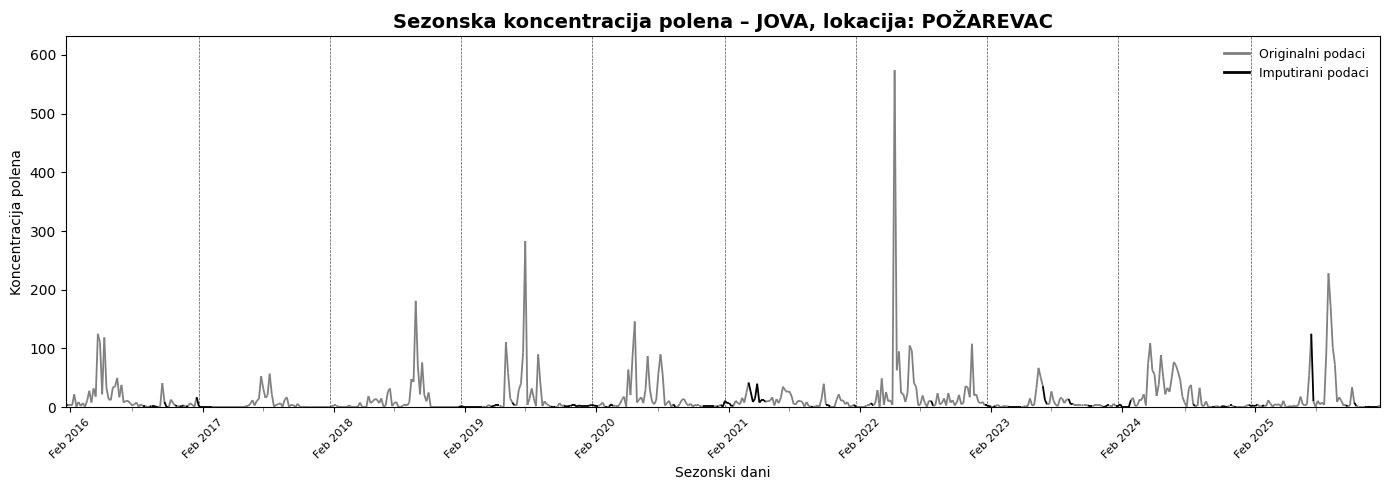

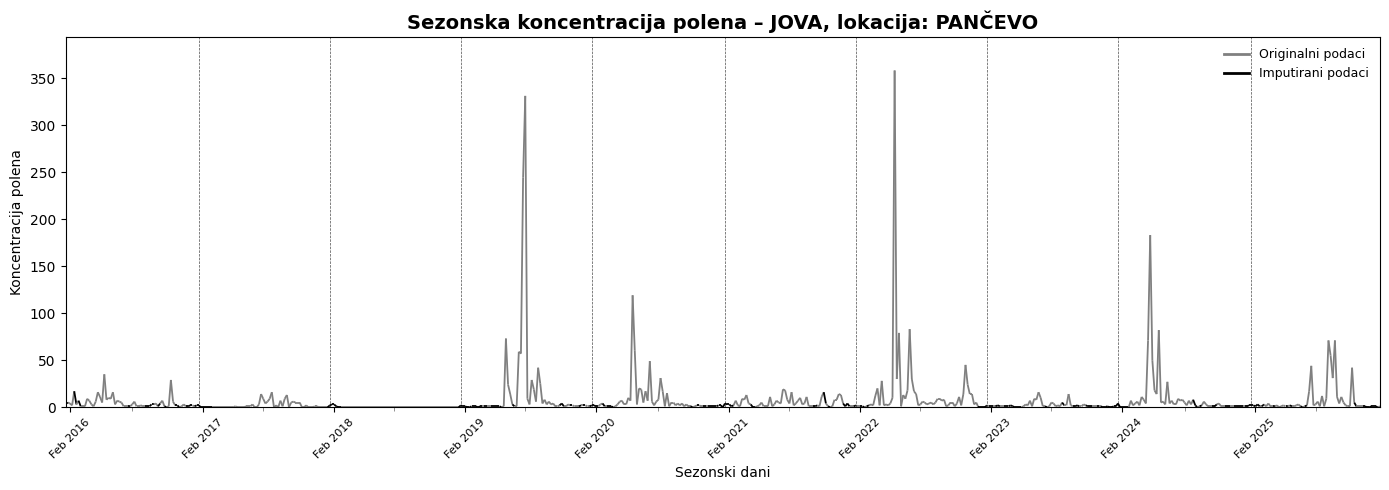

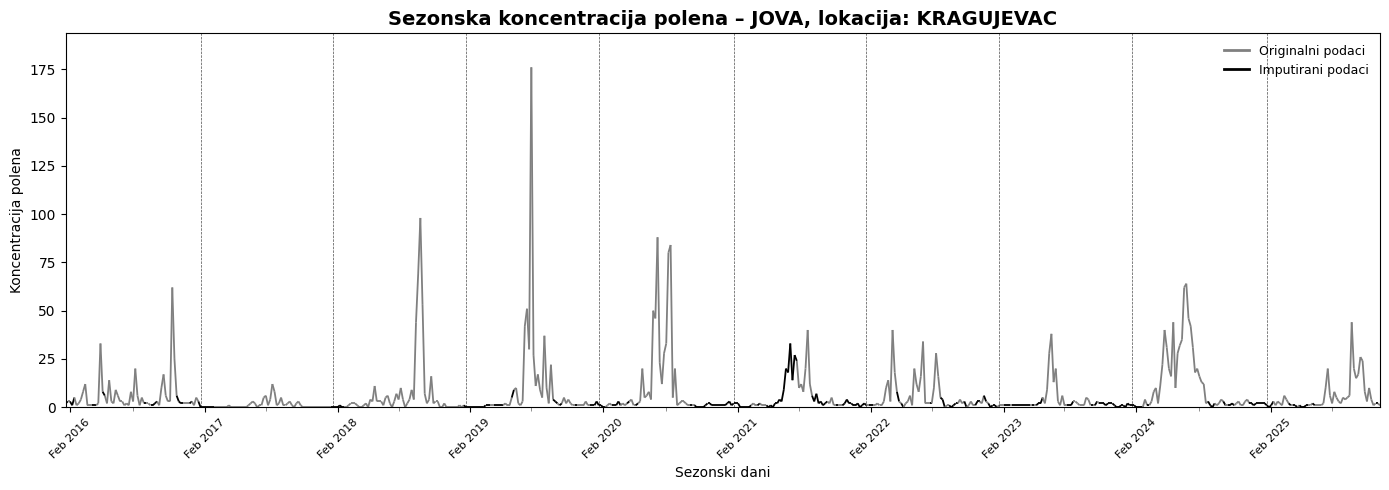

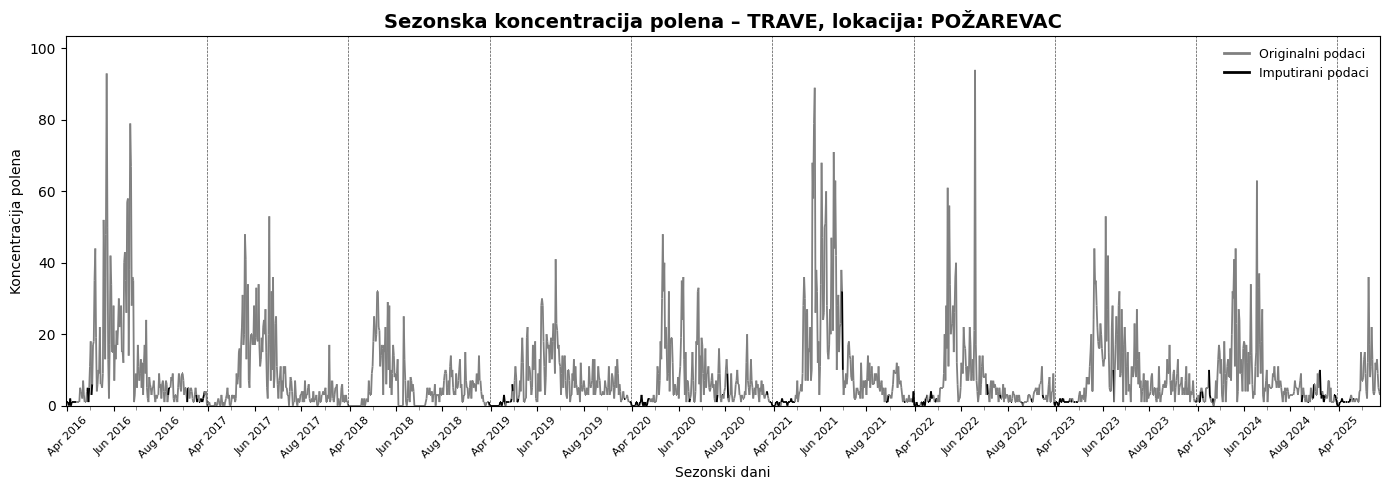

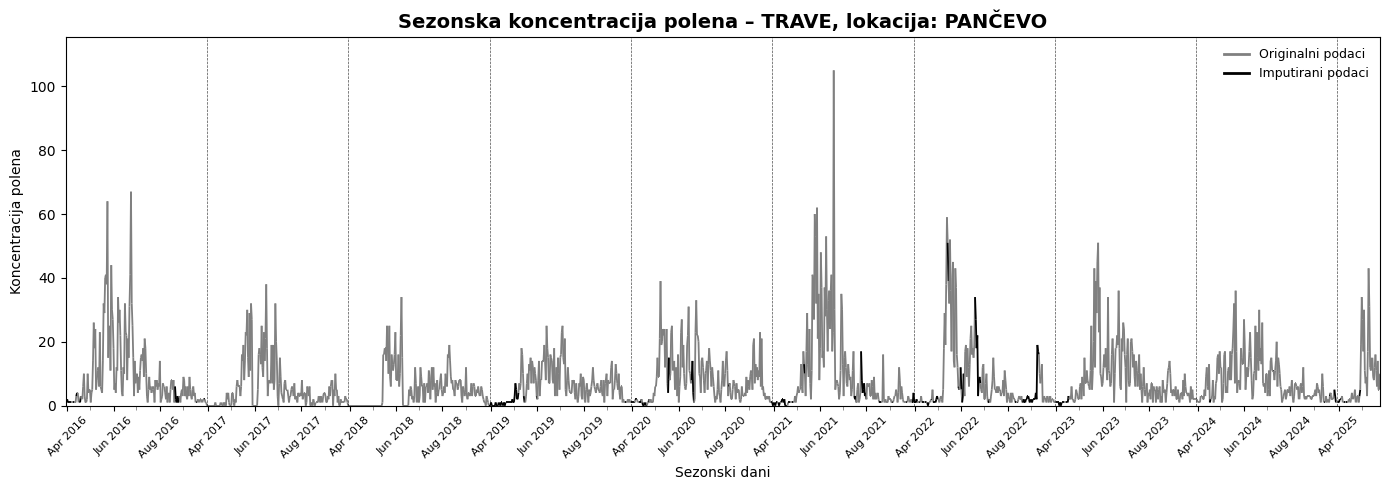

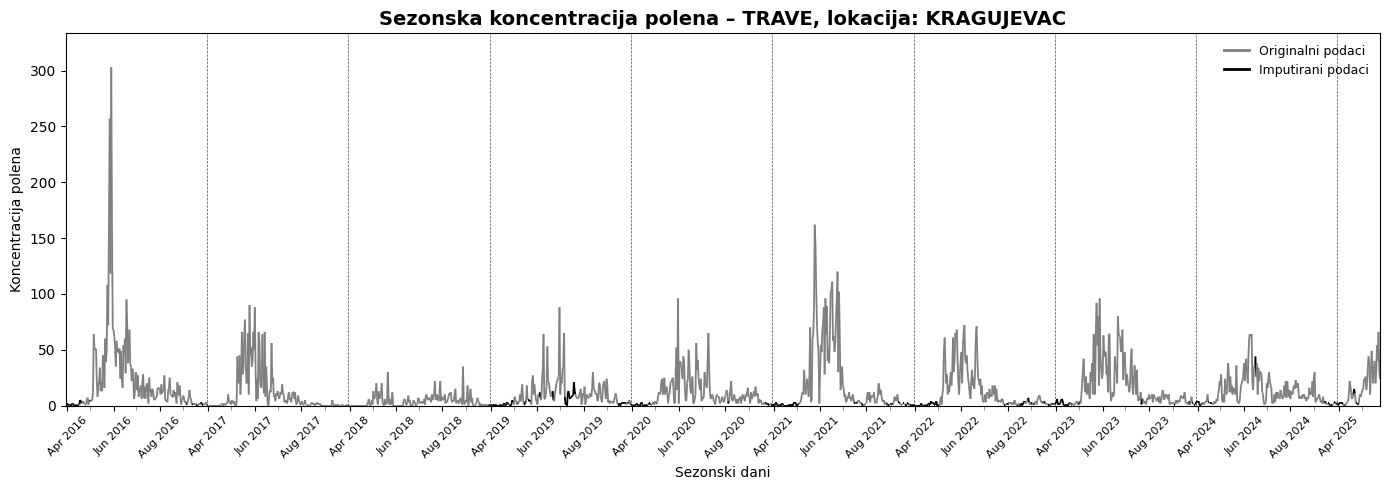

In [68]:
allergens = ['AMBROZIJA', 'JOVA', 'TRAVE']
cities = ['POŽAREVAC', 'PANČEVO', 'KRAGUJEVAC']

# Petlja kroz sve gradove i alergene
for allergen in allergens:
    for city in cities:
        subset = kriging_df[(kriging_df['location'] == city) & (kriging_df['allergen'] == allergen)]

        if not subset.empty:
            plot_seasonal_concentration_imp(subset, mode = 1)
